In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import seaborn as sns
import warnings
import datetime as dt
from datetime import timedelta
warnings.filterwarnings('ignore')
sns.set()

## 5A.1 Feature Selection

In [2]:
%store -r feature_baseline

In [3]:
feature_baseline.head()

,resale_price,resale_date,resale_year,resale_month,resale_quarter,lease_commence_year,storey_range,town,flat_model,floor_area_sqm
7925,233000.0,2017-06-01,2017,Jun,Q2,1986,2,ANG MO KIO,IMPROVED,45.0
7926,250000.0,2017-06-01,2017,Jun,Q2,1978,2,ANG MO KIO,IMPROVED,44.0
7927,235000.0,2017-06-01,2017,Jun,Q2,1976,2,ANG MO KIO,NEW GENERATION,67.0
7928,260000.0,2017-06-01,2017,Jun,Q2,1980,2,ANG MO KIO,NEW GENERATION,68.0
7929,260000.0,2017-06-01,2017,Jun,Q2,1981,0,ANG MO KIO,NEW GENERATION,68.0


In [4]:
# create a combination of feature
# for the baseline model, we do not incorporate SARIMA components
# so for the trend and seasonality, we try to rely on resale_year and resale_month
# I did try using resale_quarter instead of resale_month
# but the result is almost the same
# however, using resale_month is easier to interpret

feat = feature_baseline.drop('resale_quarter', axis = 1)
feat.shape

# Here we have 10 variables, including the target

(152529, 9)

In [5]:
feat.head()

,resale_price,resale_date,resale_year,resale_month,lease_commence_year,storey_range,town,flat_model,floor_area_sqm
7925,233000.0,2017-06-01,2017,Jun,1986,2,ANG MO KIO,IMPROVED,45.0
7926,250000.0,2017-06-01,2017,Jun,1978,2,ANG MO KIO,IMPROVED,44.0
7927,235000.0,2017-06-01,2017,Jun,1976,2,ANG MO KIO,NEW GENERATION,67.0
7928,260000.0,2017-06-01,2017,Jun,1980,2,ANG MO KIO,NEW GENERATION,68.0
7929,260000.0,2017-06-01,2017,Jun,1981,0,ANG MO KIO,NEW GENERATION,68.0


## 5A.2 Model Building

In [6]:
dummies = pd.get_dummies(feat, drop_first= True, prefix_sep= '.') #create dummy variables
dummies.head()

# After creating dummy variables, the variables becomes 62, including the target

,resale_price,resale_date,resale_year,lease_commence_year,storey_range,floor_area_sqm,resale_month.Feb,resale_month.Mar,resale_month.Apr,resale_month.May,...,flat_model.MULTI GENERATION,flat_model.NEW GENERATION,flat_model.PREMIUM APARTMENT,flat_model.PREMIUM APARTMENT LOFT,flat_model.PREMIUM MAISONETTE,flat_model.SIMPLIFIED,flat_model.STANDARD,flat_model.TERRACE,flat_model.TYPE S1,flat_model.TYPE S2
7925,233000.0,2017-06-01,2017,1986,2,45.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7926,250000.0,2017-06-01,2017,1978,2,44.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7927,235000.0,2017-06-01,2017,1976,2,67.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7928,260000.0,2017-06-01,2017,1980,2,68.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7929,260000.0,2017-06-01,2017,1981,0,68.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [7]:
dummies.shape

(152529, 62)

In [8]:
feature_baseline.groupby('resale_year').size().cumsum() / len(feature_baseline) * 100

# since in time series data we can not use traditional train-test split
# we split the train and test dataset using month and year

resale_year
2017      8.133535
2018     22.257407
2019     36.786447
2020     52.060264
2021     71.101889
2022     88.600201
2023    100.000000
dtype: float64

In [9]:
# Here I pick Aug 2022 as the limit of train dataset (1 year before the last date)
# Which is close to 80:20 split

filter_year = dummies['resale_date'] <= 'Aug 2022'
dummies = dummies.drop(['resale_date'], axis = 1) #drop resale_date because it is unusable in the model
train = dummies[filter_year] # training dataset
test = dummies[~filter_year] # testing dataset

In [10]:
X_train = train.iloc[:, 1:] # training predictors
X_test = test.iloc[:, 1:] # testing predictors
y_train = train.iloc[:, 0] # training target
y_test = test.iloc[:, 0] # testing target

In [11]:
import statsmodels.api as sm

LinearRegression = sm.OLS(y_train, sm.add_constant(X_train)).fit()
LR_summary = LinearRegression.summary()
print(LR_summary)

# From the summary below, we get the R-squared of 86%, which is high
# The predictors p-values also indicate that those feature are mostly statistically significant

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                 1.314e+04
Date:                Fri, 27 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:36:32   Log-Likelihood:            -1.5701e+06
No. Observations:              126249   AIC:                         3.140e+06
Df Residuals:                  126188   BIC:                         3.141e+06
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

## 5A.3 Visual Evaluation

In [12]:
# create prediction based on training dataset
y_train_pred = LinearRegression.predict(sm.add_constant(X_train))
y_train_pred_df = pd.concat([feature_baseline['resale_date'], y_train_pred], axis = 1) # dates after Aug 2022 are empty

In [13]:
# create prdiction based on testing dataset
y_test_pred = LinearRegression.predict(sm.add_constant(X_test))
y_test_pred_df = pd.concat([feature_baseline['resale_date'], y_test_pred], axis = 1) # dates before Sep 2022 are empty

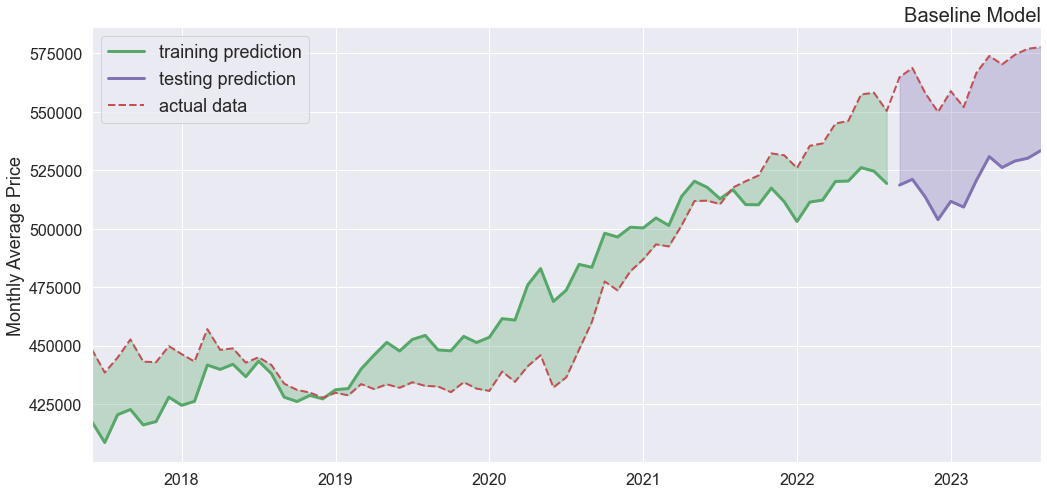

In [14]:
# Compare the training and testing predictions with actual dataset
fontsize1 = 20
fontsize2 = 16
alpha = 0.3

plot1 = y_train_pred_df.groupby('resale_date')[0].mean()
plot2 = y_test_pred_df.groupby('resale_date')[0].mean()
plot3 = feature_baseline.groupby('resale_date')['resale_price'].mean()

plt.figure(figsize=[17,8])

plot1.plot(color = 'g', label = 'training prediction', linewidth = 3)
plot2.plot(color = 'm', label = 'testing prediction', linewidth = 3)
plot3.plot(color = 'r', label = 'actual data', linestyle = '--', linewidth = 2)

plt.fill_between(plot3.index, plot1, plot3, color = 'g', alpha = alpha)
plt.fill_between(plot3.index, plot2, plot3, color = 'm', alpha = alpha)


plt.legend(fontsize = fontsize2+2)
plt.title('Baseline Model', fontsize = fontsize1, loc = 'right')

plt.xlabel('', fontsize = fontsize2)
plt.ylabel('Monthly Average Price', fontsize = fontsize2+2)

plt.xticks(fontsize = fontsize2)
plt.yticks(fontsize = fontsize2)
plt.savefig('Baseline Model Graph.png');

# From the graph below, we can tell that our baseline model can capture seasonality fairly well
# However, the model is bad at predicting trend, especially for test dataset

In [15]:
train_residual = y_train_pred - y_train
test_residual = y_test_pred - y_test

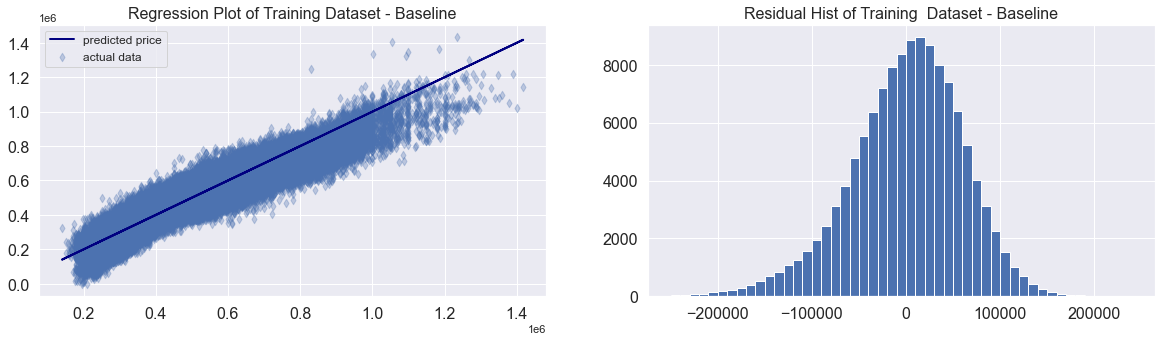

In [16]:
plt.figure(figsize=[20,5])

plt.subplot(1,2,1)
plt.scatter(y_train, y_train_pred, marker = 'd', alpha = 0.3, label = 'actual data')
plt.plot(y_train, y_train, linewidth = 2, label = 'predicted price', color = 'navy')
plt.title('Regression Plot of Training Dataset - Baseline', fontsize = fontsize1-4)
plt.legend(fontsize = fontsize2-4)
plt.xticks(fontsize = fontsize2)
plt.yticks(fontsize = fontsize2)

plt.subplot(1,2,2)
bins = np.arange(-250000, 250000, 10000)
plt.hist(train_residual, bins = bins)
plt.title('Residual Hist of Training  Dataset - Baseline', fontsize = fontsize1-4)
plt.xticks(fontsize = fontsize2)
plt.yticks(fontsize = fontsize2)

plt.savefig('Residual - Baseline.png');

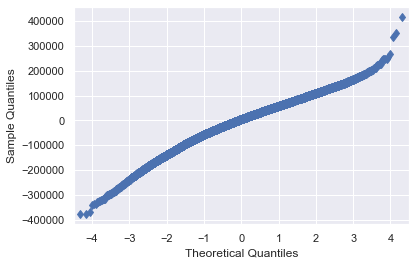

In [41]:
sm.qqplot(train_residual, marker = 'd');

In [18]:
train_residual.mean()

#close to zero

-6.87166659066154e-07

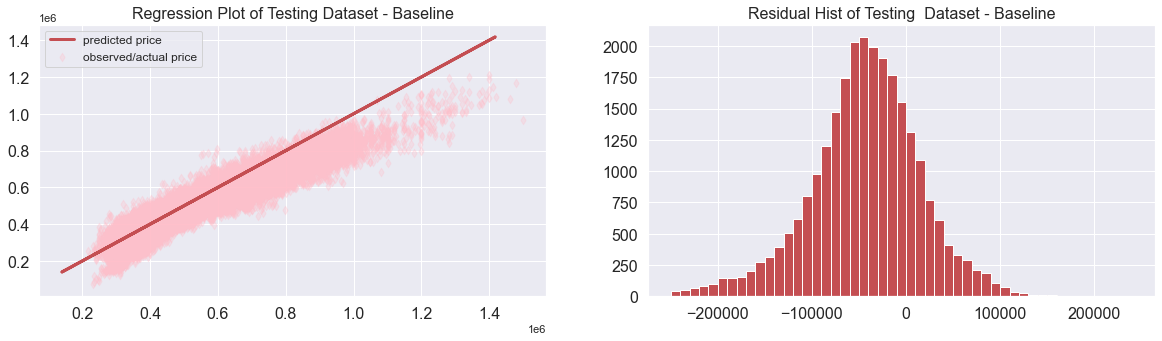

In [19]:
plt.figure(figsize = [20,5])

plt.subplot(1,2,1)
plt.scatter(y_test, y_test_pred, marker = 'd', color = 'pink', alpha = 0.3, label = 'observed/actual price')
plt.plot(y_train, y_train, color = 'r', linewidth = 3, label = 'predicted price')
plt.title('Regression Plot of Testing Dataset - Baseline', fontsize = fontsize1-4)
plt.legend(fontsize = fontsize2-4)
plt.xticks(fontsize = fontsize2)
plt.yticks(fontsize = fontsize2)

plt.subplot(1,2,2)
plt.hist(test_residual, bins = bins, color = 'r')
plt.title('Residual Hist of Testing  Dataset - Baseline', fontsize= fontsize1-4)
plt.xticks(fontsize = fontsize2)
plt.yticks(fontsize = fontsize2)

plt.savefig('Residual of Test - Baseline.png');

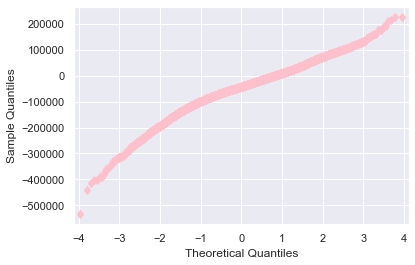

In [35]:
sm.qqplot(test_residual, marker = 'd', markerfacecolor = 'pink', markeredgecolor = 'pink');

In [21]:
test_residual.mean()

# The mean is far from zero

-45370.00643142565

## 5A.4 Metrics Evaluation

### regression metrics

In [22]:
print(f'R-Squared = {LinearRegression.rsquared*100:.3f} %')
print(f'R-Squared Adjusted = {LinearRegression.rsquared_adj*100:.3f} %')

R-Squared = 86.204 %
R-Squared Adjusted = 86.198 %


In [23]:
from sklearn.metrics import mean_absolute_error as MAE

test_MAE = MAE(y_test, y_test_pred)
train_MAE = MAE(y_train, y_train_pred)
delta_MAE = (test_MAE - train_MAE)/train_MAE*100

In [24]:
mean_resale_price = feature_baseline.groupby('resale_date')['resale_price'].mean()

In [25]:
# Furthermore, from the MAE values
# we can see that MAE from train dataset is slightly below 10% than the mean of actual monthly resale price
# However, the MAE from testing dataset diverged significantly from MAE of training dataset, at 30%

print(f'Mean of Actual Monthly Resale Price: ', f'SGD {mean_resale_price.mean():.2f}')
print(f'MAE of test dataset: ', f'{test_MAE:.2f}')
print(f'MAE of train dataset: ', f'{train_MAE:.2f}')
print(f'MAE change: ', f'{delta_MAE:.2f}'+'%')

Mean of Actual Monthly Resale Price:  SGD 483783.74
MAE of test dataset:  59158.32
MAE of train dataset:  47453.50
MAE change:  24.67%


In [26]:
baseline_MAE = {'Baseline': [train_MAE, test_MAE, delta_MAE]}

In [27]:
from sklearn.metrics import mean_squared_error as MSE

test_MSE = MSE(y_test, y_test_pred)
train_MSE = MSE(y_train, y_train_pred)
delta_MSE = (test_MSE - train_MSE)/train_MSE*100

In [28]:
print(f'MSE of test dataset: ', f'{test_MSE:.3f}')
print(f'MSE of train dataset: ', f'{train_MSE:.3f}')
print(f'MSE change: ', f'{delta_MSE:.2f}'+'%')

MSE of test dataset:  5915940120.919
MSE of train dataset:  3712888989.819
MSE change:  59.34%


### time-series metrics

In [30]:
price_time = feature_baseline.groupby('resale_date')['resale_price'].mean()
filter_year1 = price_time.index <= 'Aug 2022'

price_time_train = price_time[filter_year1]
price_time_test = price_time[~filter_year1]

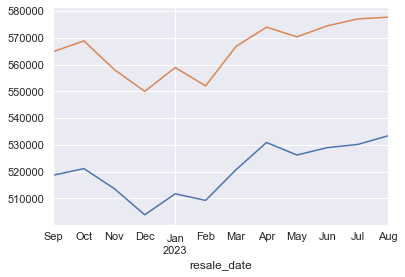

In [31]:
y_test_pred_df.groupby('resale_date')[0].mean().dropna().plot()
price_time_test.plot();

In [32]:
test_ts_MAE = MAE(y_train_pred_df.groupby('resale_date')[0].mean().dropna(), price_time_train)
train_ts_MAE = MAE(y_test_pred_df.groupby('resale_date')[0].mean().dropna(), price_time_test)

In [33]:
test_ts_MSE = MSE(y_train_pred_df.groupby('resale_date')[0].mean().dropna(), price_time_train)
train_ts_MSE = MSE(y_test_pred_df.groupby('resale_date')[0].mean().dropna(), price_time_test)

In [34]:
print(f'MAE of train dataset: ', f'{train_ts_MAE:.3f}')
print(f'MAE of train dataset: ', f'{test_ts_MAE:.3f}')

MAE of train dataset:  45332.933
MAE of train dataset:  17976.825
